In [1]:
import numpy as np
import gvar as gv
import sys
sys.path.append('../')
from h5glance import H5Glance 
import os
import lsqfit
import io
import yaml
import matplotlib
import matplotlib.pyplot as plt
import warnings  
warnings.simplefilter(action="default")

warnings.filterwarnings('ignore') 

In [2]:
os.chdir('../../nucleon_sigma/xpt')

In [3]:
import fit_analysis as fa 
import fit_routine as fit
import i_o
import priors
import fpi_fit
import mpi_fit
import plots

In [4]:
from priors import prior
prior = prior

In [5]:
input_output=i_o.InputOutput()
data,all_ensembles= input_output.get_data(scheme='w0_org',units='phys',include_phys=False)
phys_point_data = input_output.get_data_phys_point()
        #new_prior = input_output.make_prior(data,prior)
print(all_ensembles)
    

['a09m135', 'a09m220']


In [6]:
x = (273**3)/ 92**2 #* (3.5) * 2 
x

2403.8772448015125

In [7]:
np.sqrt(18053)

134.36145280548286

In [8]:
data

{'m_k': array([0.218500(78), 0.228703(91)], dtype=object),
 'm_pi': array([0.059444(63), 0.097896(63)], dtype=object),
 'eps_pi': array([0.11619(33), 0.18197(37)], dtype=object),
 'lam_chi': array([0.5116(13), 0.53796(99)], dtype=object),
 'm_proton': array([0.4240(32), 0.4353(95)], dtype=object),
 'm_delta': array([0.6109(57), 0.587(29)], dtype=object),
 'eps_proton': array([0.8287(63), 0.809(17)], dtype=object),
 'Fpi': array([91.40(77), 96.11(80)], dtype=object),
 'eps2_a': array([0.065325(70), 0.066506(83)], dtype=object),
 'm_q': array([3.648(29), 10.524(84)], dtype=object)}

In [15]:
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)
#prior['M_sq'] = gv.gvar(140, 20) 

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,750)
l_3 = {}
for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):
    ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
    print(ensembles)
    if len(ensembles) >= 2:
        ensembles = ensembles[:2]
    #
    print(ensembles)
    data,ensembles= input_output.get_data(scheme='w0_org',units='phys',include_phys=False)
    fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
    fit = fit_mpi.fit
    # mpi^2 is extrapolation #
    extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
    extrap = extrap_mpi.fitfcn(p=fit.p) * phys_point_data['hbarc']
    print(fit,extrap)
    l_3[a_xx] = {}
    l_3[a_xx]['l_3'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    l_3[a_xx]['q'] = fit.Q
    print(l_3)

['a09m135', 'a09m220']
['a09m135', 'a09m220']
Least Square Fit:
  chi2/dof [dof] = 1.8 [2]    Q = 0.17    logGBF = -19.38

Parameters:
              B       2478 (37)      [    3000 (750) ]  
            l_3       0.23 (15)      [     0.31 (16) ]  
       eps_pi 0    0.11619 (33)      [  0.11619 (33) ]  
              1    0.18198 (37)      [  0.18197 (37) ]  
          m_q 0      3.663 (28)      [    3.648 (29) ]  
              1     10.478 (80)      [   10.524 (84) ]  
         m_pi 0   0.059444 (63)      [ 0.059444 (63) ]  
              1   0.097896 (63)      [ 0.097896 (63) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 6/0.0)
 [3.501(45)e+06 9.83(12)e+06]
{'a09': {'l_3': 3.36(62), 'q': 0.16980871740345416}}


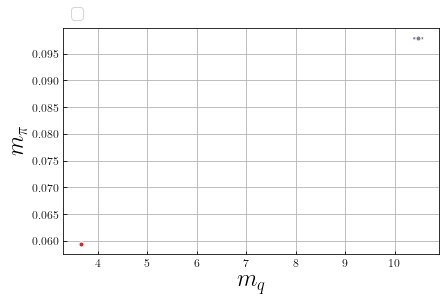

In [10]:
xparam = 'm_q'
yparam = 'm_pi'

colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

x = {}
y = {}

for i in  range(len(all_ensembles)):
    for j, param in enumerate([xparam, yparam]):
        if param =='m_q':
            value = fit.p['m_q'][i]
            label = '$m_q$'
        if param =='m_pi':
            value = fit.p['m_pi'][i] 
            label = '$m_\pi$'
        
        if j == 0:
            x[i] = value
            xlabel = label
        elif j == 1:
            y[i] = value
            ylabel = label

for i in range(len(all_ensembles)):
    C = gv.evalcov([x[i], y[i]])
    eVe, eVa = np.linalg.eig(C)
    for e, v in zip(eVe, eVa.T):
        plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                    alpha=1.0, lw=2)
        plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                    marker='o', mec='w', zorder=3)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
    ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
plt.grid()
plt.xlabel(xlabel, fontsize = 24)
plt.ylabel(ylabel, fontsize = 24)
#plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

fig = plt.gcf()
plt.show()
plt.close()

#plots.plot_parameters(ensembles=ensembles,fit=fit,xparam='m_q', yparam='eps2_a')
#len(ensembles)


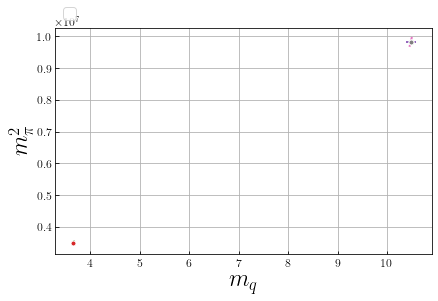

In [11]:
xparam = 'm_q'
yparam = 'm_pi_sq'

colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

x = {}
y = {}

for i in  range(len(all_ensembles)):
    for j, param in enumerate([xparam, yparam]):
        if param =='m_q':
            value = fit.p['m_q'][i]
            label = '$m_q$'
        if param =='m_pi':
            value = fit.p['m_pi'][i]
            label = '$m_\pi$'

        if param =='m_pi_sq':
            value = extrap[i]
            label = '$m_\pi^2$'
        
        if j == 0:
            x[i] = value
            xlabel = label
        elif j == 1:
            y[i] = value
            ylabel = label

for i in range(len(all_ensembles)):
    C = gv.evalcov([x[i], y[i]])
    eVe, eVa = np.linalg.eig(C)
    for e, v in zip(eVe, eVa.T):
        plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                    alpha=1.0, lw=2)
        plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                    marker='o', mec='w', zorder=3)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
    ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
plt.grid()
plt.xlabel(xlabel, fontsize = 24)
plt.ylabel(ylabel, fontsize = 24)
#plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

fig = plt.gcf()
plt.show()
plt.close()

#plots.plot_parameters(ensembles=ensembles,fit=fit,xparam='m_q', yparam='eps2_a')
#len(ensembles)


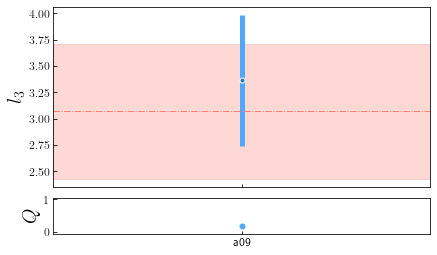

In [12]:
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
fig, (ax_value, ax_q) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [5, 1], 'wspace':0.0, 'hspace':0.1})
ax_value.errorbar(
    x=-np.arange(len(l_3)), 
    y=gv.mean([l_3[a_xx]['value'] for a_xx in l_3]), 
    xerr=0.0, 
    yerr=gv.sdev([l_3[a_xx]['value'] for a_xx in l_3]),
    capsize=0.0, mec='white', ms=10.0,
    ecolor=[colormap[a_xx] for a_xx in l_3], 
    elinewidth=5.0, fmt = '.')
ax_q.scatter(
    x=-np.arange(len(l_3)), 
    y=[l_3[a_xx]['q'] for a_xx in l_3], 
    color=[colormap[a_xx] for a_xx in l_3])

ax_value.set_ylabel('$l_3$')
ax_q.set_ylabel('$Q$')
ax_q.set_ylim(-0.05, 1.05)

ax_value.set_xticks(-np.arange(len(l_3)))
ax_value.set_xticklabels([a_xx for a_xx in l_3])

pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='salmon', label='PDG/FLAG')
ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='salmon')

#fig.savefig('../tmp/l_3_vs_epsa.png')
plt.show()

## Mpi^2 vs. m_q ##

## Mpi vs m_q ##

## NLO CONTINUUM fit 

In [13]:
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)
#prior['M_sq'] = gv.gvar(140, 20) 

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2))
#prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
#prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
#prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
# prior['d_{mpi,ll}'] = gv.gvar(0,4)
# prior['d_{mpi,al}'] = gv.gvar(0,4)
# prior['d_{mpi,aa}'] = gv.gvar(0,4)
l_3 = {}
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

results = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  ensembles]):
    ensembles_ = [ens for ens in ensembles if ens.startswith(a_xx)]
    if len(ensembles_) >= 2:
        ensembles_ = ensembles_[:5]
        data, ensembles_ = input_output.get_data(scheme='w0_org',units='phys',include_phys=False)

        #mass_average = xpt.mass.MassAverage(data, data_phys_point, prior, models, ensembles)
        #fit = mass_average.fitter().fit
        results[a_xx] = {}
        results[a_xx]['posterior'] = {key : [] for key in prior}
        results[a_xx]['q'] = []
        results[a_xx]['prior'] = {key : [] for key in prior}
        results[a_xx]['logGBF'] = [] 
        for prior_width in np.linspace(1, 20, 10):
            prior['c_{mpi,2F}'] = gv.gvar(0, prior_width)
            prior['c_{mpi,1F}'] = gv.gvar(0, prior_width)
            prior['l_3'] = gv.gvar(0, prior_width)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            #for key in prior:
                # if key == 'l_3':
                #     results[a_xx]['posterior']['l_3'].append(fit.p['l_3'] - np.log(phys_point_data['eps_pi']**2))
                #     results[a_xx]['prior']['l_3'].append(fit.prior['l_3'] - np.log(phys_point_data['eps_pi']**2))
                # else:
                #     results[a_xx]['posterior'][key].append(fit.p[key])
                #     results[a_xx]['prior'][key].append(fit.prior[key])

            results[a_xx]['posterior']['l_3'].append(fit.p['l_3'] - np.log(phys_point_data['eps_pi']**2))
            results[a_xx]['prior']['l_3'].append(fit.prior['l_3'] - np.log(phys_point_data['eps_pi']**2))
            results[a_xx]['q'].append(fit.Q)
            results[a_xx]['logGBF'].append(fit.logGBF)
            

fig, (ax_value_a09, ax_q_a09, ax_w_a09, ax_value_a12, ax_q_a12, ax_w_a12, ax_value_a15, ax_q_a15, ax_w_a15) = plt.subplots(nrows=9, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 5, 1, 1, 5, 1, 1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q, ax_w in zip(results, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15], [ax_w_a09, ax_w_a12, ax_w_a15]):

    lec = 'l_3'
    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)

    x = gv.sdev(results[a_xx]['prior']['l_3'])
    ax_value.plot(
        x, 
        pm(results[a_xx]['posterior'][lec], 0),
        color=colormap[a_xx], ls='--'
    )

    ax_value.plot(
        x, 
        pm(results[a_xx]['posterior'][lec], -1),
        x, 
        pm(results[a_xx]['posterior'][lec], 1),
        color=colormap[a_xx]
    )

    ax_value.fill_between(
        x,
        pm(results[a_xx]['posterior'][lec], 1),
        pm(results[a_xx]['posterior'][lec], -1),
        facecolor=colormap[a_xx], alpha=0.7
    )

    #ax_value.axhspan(pm(l_4_flag, -1), pm(l_4_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    #ax_value.axhline(pm(l_4_flag, 0), ls='-.', color='grey')

    ax_q.plot(
        x, 
        results[a_xx]['q'], 
        color=colormap[a_xx]
    )

    ax_w.plot(
        x, 
        np.exp(np.array(results[a_xx]['logGBF'])-results[a_xx]['logGBF'][0]), 
        color=colormap[a_xx]
    )

    ax_value.set_ylabel('$%s$'%(lec))
    ax_q.set_ylabel('$Q$')
    ax_q.set_ylim(-0.05, 1.05)

    ax_w.set_ylabel('BF')

    #if (y_ax_min is not None) and (y_ax_max is not None):
    #    ax_value.set_ylim(y_ax_min, y_ax_max)
        

ax_w_a15.set_xlabel('$\sigma$')

#fig.savefig('../tmp/l_4_vs_prior_width.png')
plt.show()

KeyError: 'B'

In [ ]:
print(results)

{}


In [ ]:
fit_mpi = mpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_mpi)
fit_mpi_out = fit_mpi.fit
extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
extrap = extrap_mpi.fitfcn(p=fit_mpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_mpi_out.format(True))

NameError: name 'new_prior' is not defined

## B vs $\epsilon_a^2$

## $\bar{l}_3$ vs $\epsilon_a^2$

## N2LO CONTINUUM fit 

In [ ]:
fit_mpi = mpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_mpi)
fit_mpi_out = fit_mpi.fit
extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
extrap = extrap_mpi.fitfcn(p=fit_mpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_mpi_out.format(True))